In [41]:
import os
import subprocess
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

# Model testing

In [42]:
class ModelPipeline:
    def __init__(self, csv_path, skip_rows, random_state):
        self.csv_path = csv_path
        self.skip_rows = skip_rows
        self.df = self._load_data()
        self.X = self.df[[
            "home_team_name",
            "away_team_name",
            "home_team_rank",
            "away_team_rank",
            "day_of_week",
            #"hour_of_day",
            #"home_team_points",
            #"away_team_points",
            #"home_team_goals_for",
            #"away_team_goals_for",
            #"home_team_goals_againsts",
            #"away_team_goals_against",
            #"home_team_goals_difference",
            #"away_team_goals_difference"
        ]]
        self.y = self.df["result"]
        self.random_state = random_state
        self.pipeline = self._create_pipeline()
        self.param_grid = self._create_param_grid()
        self.model = GridSearchCV(
            estimator=self.pipeline,
            param_grid=self.param_grid,
            scoring="accuracy",
            cv=TimeSeriesSplit(n_splits=5),
            n_jobs=-1,
            verbose=4,
        )
        self.average_train_accuracy = None
        self.average_test_accuracy = None
        self.last_split_train_accuracy = None
        self.last_split_test_accuracy = None

    def _load_data(self):
        df = pd.read_csv(self.csv_path)
        return df.iloc[self.skip_rows :].reset_index(drop=True)

    def _create_pipeline(self):
        return Pipeline(
            steps=[
                (
                    "CategoricalFeatures",
                    ColumnTransformer(
                        transformers=[
                            (
                                "cat",
                                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                                ["home_team_name", "away_team_name"],
                            ),
                            (
                                'home_team_rank', FunctionTransformer(lambda x: np.column_stack([
                                    np.cos(2 * np.pi * x / 20),
                                    np.sin(2 * np.pi * x / 20)
                                    ]), validate=True), ["home_team_rank"]
                            ),
                            (
                                'away_team_rank', FunctionTransformer(lambda x: np.column_stack([
                                    np.cos(2 * np.pi * x / 20),
                                    np.sin(2 * np.pi * x / 20)
                                    ]), validate=True), ["away_team_rank"]
                            ),
                            (
                                'day_of_week', FunctionTransformer(lambda x: np.column_stack([
                                    np.cos(2 * np.pi * x / 7),
                                    np.sin(2 * np.pi * x / 7)
                                    ]), validate=True), ["day_of_week"]
                            ),
                            #('home_team_points', SimpleImputer(strategy='mean'), ['home_team_points']),
                            #('away_team_points', SimpleImputer(strategy='mean'), ['away_team_points']),
                            #('home_team_goals_for', SimpleImputer(strategy='mean'), ['home_team_goals_for']),
                            #('away_team_goals_for', SimpleImputer(strategy='mean'), ['away_team_goals_for']),
                            #('home_team_goals_againsts', SimpleImputer(strategy='mean'), ['home_team_goals_againsts']),
                            #('away_team_goals_against', SimpleImputer(strategy='mean'), ['away_team_goals_against']),
                            #('home_team_goals_difference', SimpleImputer(strategy='mean'), ['home_team_goals_difference']),
                            #('away_team_goals_difference', SimpleImputer(strategy='mean'), ['away_team_goals_difference'])
                        ]
                    ),
                ),
                ("StandardScaler", StandardScaler(with_mean=True)),
                ("SGDClassifier", SGDClassifier(random_state=self.random_state, max_iter=1000)),
            ]
        )

    def _create_param_grid(self):
        return {
            "SGDClassifier__tol": [1e-2, 1e-3, 1e-4],
            "SGDClassifier__alpha": [1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
            "SGDClassifier__penalty": ["l2", "l1", "elasticnet"],
            "SGDClassifier__loss": ["hinge", "log_loss", "modified_huber"],
        }

    def train(self):
        tscv = TimeSeriesSplit(n_splits=10)
        scores = []
        split_ranges = []  # Aquí inicializamos split_ranges

        # Iterate over the splits
        for split, (train_index, test_index) in enumerate(tscv.split(self.X), 1):
            # Split data into training and test sets
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            self.model.fit(X_train, y_train)  # Fit the model to the training data
            accuracy_train = self.model.score(X_train, y_train)  # Calculate training accuracy
            accuracy_test = self.model.score(X_test, y_test)  # Calculate test accuracy
            scores.append((accuracy_train, accuracy_test))  # Store the scores for this split
            y_pred = self.model.predict(X_test)
            errors = y_test != y_pred
            error_df = self.df.iloc[test_index][errors][["home_team_name", "away_team_name", "result"]]
            
            # Team statistics for test set (sorted by error percentage)
            team_stats_test = {}
            for team in pd.concat([self.df.iloc[test_index]["home_team_name"], self.df.iloc[test_index]["away_team_name"]]).unique():
                total_matches = ((self.df.iloc[test_index]["home_team_name"] == team) | (self.df.iloc[test_index]["away_team_name"] == team)).sum()
                total_errors = ((error_df["home_team_name"] == team) | (error_df["away_team_name"] == team)).sum()
                error_percentage = (total_errors / total_matches) * 100 if total_matches > 0 else 0
                team_stats_test[team] = {"total_matches": total_matches, "total_errors": total_errors, "error_percentage": error_percentage}

            # Team statistics for train set (sorted by error percentage from test set)
            y_train_pred = self.model.predict(X_train)
            train_errors = y_train != y_train_pred
            train_error_df = self.df.iloc[train_index][train_errors][["home_team_name", "away_team_name", "result"]]
            
            team_stats_train = {}
            for team in pd.concat([self.df.iloc[train_index]["home_team_name"], self.df.iloc[train_index]["away_team_name"]]).unique():
                total_matches = ((self.df.iloc[train_index]["home_team_name"] == team) | (self.df.iloc[train_index]["away_team_name"] == team)).sum()
                total_errors = ((train_error_df["home_team_name"] == team) | (train_error_df["away_team_name"] == team)).sum()
                error_percentage = (total_errors / total_matches) * 100 if total_matches > 0 else 0
                team_stats_train[team] = {"total_matches": total_matches, "total_errors": total_errors, "error_percentage": error_percentage}
            
            # Combine train and test stats manually
            all_team_stats = {}
            for team in team_stats_test:
                if team in team_stats_train:
                    all_team_stats[team] = {
                        "train_stats": team_stats_train[team],
                        "test_stats": team_stats_test[team]
                    }

            # Sorting by test error percentage
            sorted_all_teams = sorted(all_team_stats.items(), key=lambda x: x[1]['test_stats']['error_percentage'], reverse=True)

            print(f"\nCombined Error Statistics for Split {split}:")
            for team, stats in sorted_all_teams:
                print(f"{team}: Train Matches={stats['train_stats']['total_matches']}, Train Errors={stats['train_stats']['total_errors']}, Train Error%={stats['train_stats']['error_percentage']:.2f}%, "
                    f"Test Matches={stats['test_stats']['total_matches']}, Test Errors={stats['test_stats']['total_errors']}, Test Error%={stats['test_stats']['error_percentage']:.2f}%")

            # Save the split ranges for plotting later
            split_ranges.append((train_index[0], train_index[-1], test_index[0], test_index[-1]))

        # Calculate the average accuracy across all splits
        self.average_train_accuracy = sum([score[0] for score in scores]) / len(scores)
        self.average_test_accuracy = sum([score[1] for score in scores]) / len(scores)
        # Store the accuracy for the last split
        self.last_split_train_accuracy = scores[-1][0]
        self.last_split_test_accuracy = scores[-1][1]

        # Print the accuracy results
        print(f"Average Train Accuracy: {self.average_train_accuracy:.4f}")
        print(f"Average Test Accuracy: {self.average_test_accuracy:.4f}")
        print(f"Last Split Train Accuracy: {self.last_split_train_accuracy:.4f}")
        print(f"Last Split Test Accuracy: {self.last_split_test_accuracy:.4f}")

        self._plot_splits(split_ranges)

        self.log_to_mlflow()

    def _plot_splits(self, split_ranges):
        plt.figure(figsize=(10, 6))
        for i, (train_start, train_end, test_start, test_end) in enumerate(split_ranges):
            plt.plot(range(train_start, train_end + 1), [i] * (train_end - train_start + 1), 'b-', label='Train' if i == 0 else "")
            plt.plot(range(test_start, test_end + 1), [i] * (test_end - test_start + 1), 'r-', label='Test' if i == 0 else "")
        plt.xlabel("Index")
        plt.ylabel("Split")
        plt.legend()
        plt.title("Time Series Cross Validation Splits")
        plt.show()

    def log_to_mlflow(self):
        # Ask if the user wants to save the model to MLflow
        save_model = input("Do you want to save the model in MLflow? (yes/no): ").strip().lower()
        if save_model not in ["yes", "y"]:
            print("Model was not saved to MLflow.")
            return  # Exit the function if the model is not to be saved

        # Ask for the run name and description
        run_name = input("Enter the run name: ").strip()
        description = input("Enter the run description: ").strip()

        # Set the experiment name and tracking URI for MLflow
        experiment_name = "BetPredictions"
        tracking_uri = os.path.abspath("mlruns")
        mlflow.set_tracking_uri(f"file:///{tracking_uri}")

        # Start the MLflow UI if it's not already running
        subprocess.Popen(f"mlflow ui --backend-store-uri file:///{tracking_uri}", shell=True)

        mlflow.set_experiment(experiment_name)

        # Log the model, metrics, parameters, and features to MLflow
        with mlflow.start_run(run_name=run_name, description=description):
            # Log the accuracy metrics
            mlflow.log_metric("Average Train Accuracy", self.average_train_accuracy)
            mlflow.log_metric("Average Test Accuracy", self.average_test_accuracy)
            mlflow.log_metric("Last Split Train Accuracy", self.last_split_train_accuracy)
            mlflow.log_metric("Last Split Test Accuracy", self.last_split_test_accuracy)

            # Log the features used in the model
            features_used = self.X.columns.tolist()
            mlflow.log_param("features", features_used)

            # Log the best hyperparameters if available
            if hasattr(self.model, 'best_params_'):
                mlflow.log_params(self.model.best_params_)

            # Print a message indicating the model has been logged
            print("Model, metrics, parameters, and features logged to MLflow.")

        # Ask if the user wants to open the MLflow UI
        open_mlflow = input("Do you want to open the MLflow UI page? (yes/no): ").strip().lower()
        if open_mlflow in ["yes", "y"]:
            # Open the MLflow experiment page in the browser
            experiment_id = "492606161886242227"  # Replace with your experiment ID
            mlflow_url = f"http://127.0.0.1:5000/#/experiments/{experiment_id}"
            # For Windows, use the 'start' command
            subprocess.Popen(f"start {mlflow_url}", shell=True)

# Results

Fitting 5 folds for each of 135 candidates, totalling 675 fits

Combined Error Statistics for Split 1:
Eibar: Train Matches=18, Train Errors=6, Train Error%=33.33%, Test Matches=17, Test Errors=13, Test Error%=76.47%
Real_Betis: Train Matches=18, Train Errors=6, Train Error%=33.33%, Test Matches=17, Test Errors=13, Test Error%=76.47%
Alaves: Train Matches=18, Train Errors=4, Train Error%=22.22%, Test Matches=17, Test Errors=12, Test Error%=70.59%
Real_Madrid: Train Matches=18, Train Errors=10, Train Error%=55.56%, Test Matches=17, Test Errors=12, Test Error%=70.59%
Osasuna: Train Matches=18, Train Errors=8, Train Error%=44.44%, Test Matches=18, Test Errors=12, Test Error%=66.67%
Sevilla: Train Matches=18, Train Errors=5, Train Error%=27.78%, Test Matches=17, Test Errors=11, Test Error%=64.71%
Villarreal: Train Matches=18, Train Errors=5, Train Error%=27.78%, Test Matches=17, Test Errors=11, Test Error%=64.71%
Celta_Vigo: Train Matches=18, Train Errors=10, Train Error%=55.56%, Test Matc

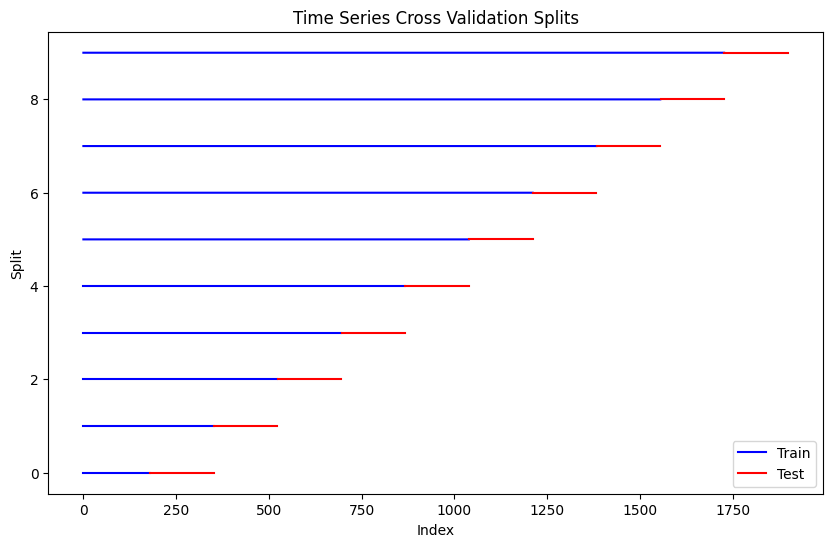

Model was not saved to MLflow.


In [43]:
csv_path = "final_dataset.csv"

skip_rows = 0

random_state = 0

pipeline = ModelPipeline(csv_path, skip_rows, random_state)

pipeline.train()

In [44]:
"""class ModelPipeline:
    def __init__(self, csv_path, skip_rows, random_state):
        self.csv_path = csv_path
        self.skip_rows = skip_rows
        self.df = self._load_data()
        self.X = self.df.drop(columns=['target'])
        self.y = self.df['target']
        self.random_state = random_state
        self.pipeline = self._create_pipeline()
        self.param_grid = self._create_param_grid()
        self.model = GridSearchCV(
            estimator=self.pipeline,
            param_grid=self.param_grid,
            scoring='f1_weighted',
            cv=TimeSeriesSplit(n_splits=5),
            n_jobs=-1,
            verbose=4
        )

    def _load_data(self):
        df = pd.read_csv(self.csv_path)
        return df.iloc[self.skip_rows:].reset_index(drop=True)

    def _create_pipeline(self):
        return Pipeline(
            steps=[
                ('CategoricalFeatures', ColumnTransformer(
                    transformers=[
                        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [
                            "home_team_name",
                            "away_team_name",
                            "referee",
                            "var",
                            "stadium",
                        ]),
                        ('gameweek', FunctionTransformer(lambda x: np.column_stack([
                            np.cos(2 * np.pi * x / 38),
                            np.sin(2 * np.pi * x / 38)
                        ]), validate=True), ["gameweek"]),
                        ('hour_of_the_day', FunctionTransformer(lambda x: np.column_stack([
                            np.cos(2 * np.pi * x / 24),
                            np.sin(2 * np.pi * x / 24)
                        ]), validate=True), ["hour_of_the_day"]),
                        ('avg_home_wins_last_10', SimpleImputer(strategy='mean'), ['avg_home_wins_last_10']),
                        ('avg_away_wins_last_10', SimpleImputer(strategy='mean'), ['avg_away_wins_last_10']),
                        ('avg_home_wins_last_5_home', SimpleImputer(strategy='mean'), ['avg_home_wins_last_3_home']),
                        ('avg_away_wins_last_5_away', SimpleImputer(strategy='mean'), ['avg_away_wins_last_3_away']),
                        ('avg_home_attendance_perc_last_10', SimpleImputer(strategy='mean'), ['avg_home_attendance_perc_last_10']),
                        ('avg_home_attendance_last_3', SimpleImputer(strategy='mean'), ['avg_home_attendance_last_3']),
                        ('avg_home_attendance_perc_last_3', SimpleImputer(strategy='mean'), ['avg_home_attendance_perc_last_3']),
                        ('avg_away_attendance_perc_last_10', SimpleImputer(strategy='mean'), ['avg_away_attendance_perc_last_10']),
                        ('avg_away_attendance_perc_last_3', SimpleImputer(strategy='mean'), ['avg_away_attendance_perc_last_3'])
                    ]
                )),
                ("StandardScaler", StandardScaler(with_mean=True)),
                ("SGDClassifier", SGDClassifier(
                    random_state=self.random_state,
                    max_iter=1000
                ))
            ]
        )

    def _create_param_grid(self):
        return {
            "SGDClassifier__tol": [1e-2, 1e-3, 1e-4],
            "SGDClassifier__alpha": [1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
            "SGDClassifier__penalty": ['l2', 'l1', 'elasticnet'],
            "SGDClassifier__loss": ['hinge', 'log_loss', 'modified_huber']
        }

    def train(self):
        tscv = TimeSeriesSplit(n_splits=5)
        scores = []
        f1_scores_train = []
        f1_scores_test = []

        for split, (train_index, test_index) in enumerate(tscv.split(self.X), 1):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            self.model.fit(X_train, y_train)
            accuracy_train = self.model.score(X_train, y_train)
            accuracy_test = self.model.score(X_test, y_test)
            scores.append((accuracy_train, accuracy_test))
            y_pred_train = self.model.predict(X_train)
            y_pred_test = self.model.predict(X_test)
            f1_train = f1_score(y_train, y_pred_train, average='weighted')
            f1_test = f1_score(y_test, y_pred_test, average='weighted')
            f1_scores_train.append(f1_train)
            f1_scores_test.append(f1_test)

        self.plot_splits(tscv)

        average_train_accuracy = sum([score[0] for score in scores]) / len(scores)
        average_test_accuracy = sum([score[1] for score in scores]) / len(scores)
        average_train_f1 = sum(f1_scores_train) / len(f1_scores_train)
        average_test_f1 = sum(f1_scores_test) / len(f1_scores_test)

        print(f"Average Train Accuracy: {average_train_accuracy:.4f}")
        print(f"Average Test Accuracy: {average_test_accuracy:.4f}")
        print(f"Average Train F1-Score: {average_train_f1:.4f}")
        print(f"Average Test F1-Score: {average_test_f1:.4f}")

    def plot_splits(self, tscv):
        plt.figure(figsize=(12, 6))
        for i, (train_index, test_index) in enumerate(tscv.split(self.X)):
            plt.plot(train_index, [i + 1] * len(train_index), '|', color='blue', label='Train Set' if i == 0 else "", markersize=10)
            plt.plot(test_index, [i + 1] * len(test_index), '|', color='orange', label='Test Set' if i == 0 else "", markersize=10)
        plt.title("División Temporal: Train vs Test")
        plt.xlabel("Índice")
        plt.ylabel("División")
        plt.legend()
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()

    def log_to_mlflow(self):
        experiment_name = "BetPredictions"
        mlflow.set_experiment(experiment_name)

        save_results = input("Do you want to save results to MLflow? (yes/no): ").strip().lower()
        if save_results == 'yes':
            run_name = input("Enter run name: ").strip()
            description = input("Enter run description: ").strip()

            with mlflow.start_run(run_name=run_name, description=description):
                if hasattr(self.model, 'best_params_'):
                    mlflow.log_params(self.model.best_params_)

                features_used = self.X.columns.tolist()
                mlflow.log_param("features", features_used)

                if hasattr(self.model, 'best_estimator_'):
                    mlflow.sklearn.log_model(self.model.best_estimator_, "best_model_pipeline")

                print("Model, metrics, parameters, and features logged to MLflow.")"""

'class ModelPipeline:\n    def __init__(self, csv_path, skip_rows, random_state):\n        self.csv_path = csv_path\n        self.skip_rows = skip_rows\n        self.df = self._load_data()\n        self.X = self.df.drop(columns=[\'target\'])\n        self.y = self.df[\'target\']\n        self.random_state = random_state\n        self.pipeline = self._create_pipeline()\n        self.param_grid = self._create_param_grid()\n        self.model = GridSearchCV(\n            estimator=self.pipeline,\n            param_grid=self.param_grid,\n            scoring=\'f1_weighted\',\n            cv=TimeSeriesSplit(n_splits=5),\n            n_jobs=-1,\n            verbose=4\n        )\n\n    def _load_data(self):\n        df = pd.read_csv(self.csv_path)\n        return df.iloc[self.skip_rows:].reset_index(drop=True)\n\n    def _create_pipeline(self):\n        return Pipeline(\n            steps=[\n                (\'CategoricalFeatures\', ColumnTransformer(\n                    transformers=[\n     